In [1]:
import pandas as pd
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing

In [2]:
# import data

raw_data = pd.read_csv("raw_data/company.csv")

# basic preprocessing

data = raw_data.copy()
data.drop_duplicates(inplace=True)
data["ACCT_ID"] = data["ACCT_ID"].astype("int").astype("string")
data["SUB_START_DATE"] = pd.to_datetime(data["SUB_START_DATE"])
data["SUB_END_DATE"] = pd.to_datetime(data["SUB_END_DATE"])

# create the metric DURATION

data["DURATION"] = data["SUB_END_DATE"] - data["SUB_START_DATE"]
data["DURATION"] = data["DURATION"].astype("string").apply(lambda x: x.replace(" days","")).astype("int")

data.head()

,ACCT_ID,SUBSCRIPTION_BILLABLE_TYPE,SUBSCRIPTION_TYPE,SKU_LENGTH,SUB_STATE,SUB_START_DATE,SUB_END_DATE,DURATION
0,188368000000000,Paid,Wallet,1 month,Reclaim,2020-03-15,2020-04-15,31
1,188368000000000,Paid,Wallet,1 month,Renewal,2020-04-15,2020-05-15,30
2,188368000000000,Paid,Wallet,1 month,Renewal,2020-05-16,2020-06-16,31
3,188368000000000,Paid,Wallet,1 month,Renewal,2020-06-16,2020-07-16,30
4,188368000000000,Paid,Wallet,1 month,Renewal,2020-07-16,2020-08-16,31


In [4]:
# create a new dataframe presenting total duration per account

total_dur = data.copy()[["ACCT_ID","DURATION"]]
total_dur = total_dur.groupby("ACCT_ID", as_index=False).sum()
total_dur.head()

,ACCT_ID,DURATION
0,100006000000000,365
1,100040000000000,61
2,100101000000000,366
3,100102000000000,365
4,100179000000000,366


# Analysis

## Global overview

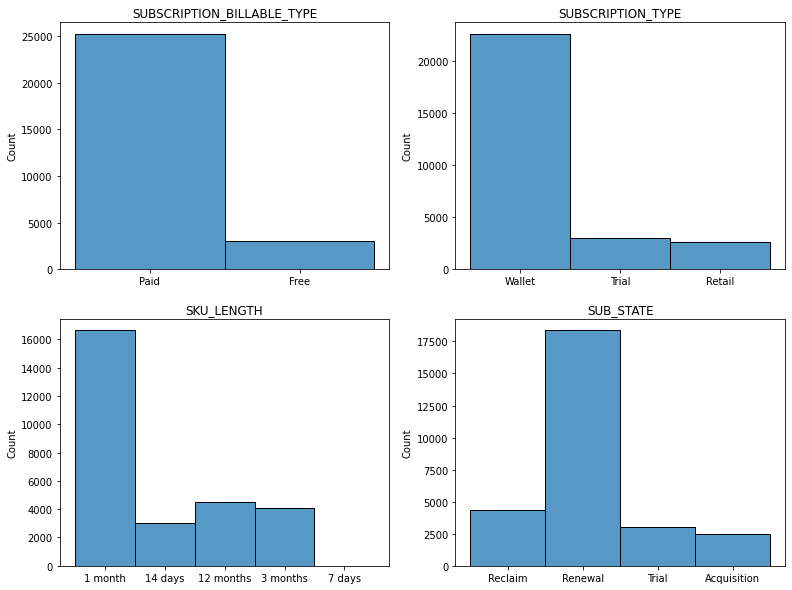

In [12]:
# Repartition 
plt.figure(figsize=(13,10))

plt.subplot(2,2,1)
plt.title("SUBSCRIPTION_BILLABLE_TYPE")
sns.histplot(data["SUBSCRIPTION_BILLABLE_TYPE"])
plt.xlabel("")

plt.subplot(2,2,2)
plt.title("SUBSCRIPTION_TYPE")
sns.histplot(data["SUBSCRIPTION_TYPE"])
plt.xlabel("")

plt.subplot(2,2,3)
plt.title("SKU_LENGTH")
sns.histplot(data["SKU_LENGTH"])
plt.xlabel("")

plt.subplot(2,2,4)
plt.title("SUB_STATE")
sns.histplot(data["SUB_STATE"])
plt.xlabel("");

**Difference between Reclaim and Renewal**

> A renewal is a subscription made *at the end* of the last one.

> A reclaim is a subscription made *later than the end* of the last subscription.

## Evolution of active subscriptions

In [5]:
# Let's first create a function to get the current active subscriptions

def current_active(date, sub_state=None):
    '''
    return current active paid subscriptions given a day like '2020-03-03' as string.
    Option to focus on the SUB_STATE
    '''
    df_paid = data.copy()
    df_paid = df_paid[df_paid["SUBSCRIPTION_BILLABLE_TYPE"] == "Paid"]
    
    if sub_state is not None:
        df_paid = df_paid[df_paid["SUB_STATE"]==sub_state]
    
    temp = df_paid[(df_paid["SUB_START_DATE"] <= date)&(df_paid["SUB_END_DATE"] >= date)]
    
    return len(temp)  

In [8]:
# Create a new df to get evolution of number of paid subscriptions

df_paid = pd.DataFrame()
df_paid["SUB_START_DATE"] = data["SUB_START_DATE"].sort_values().drop_duplicates().reset_index(drop=True)
df_paid.columns = ["DATE"]
df_paid["ACTIVE_SUB"] = df_paid["DATE"].apply(lambda x: current_active(x))
df_paid["PERC_CHANGE"] = df_paid["ACTIVE_SUB"].pct_change()
df_paid.set_index("DATE", inplace=True)
df_paid["MONTHLY_PERC_CHANGE"] = df_paid["ACTIVE_SUB"].pct_change(freq="M")
df_paid.head()

,ACTIVE_SUB,PERC_CHANGE,MONTHLY_PERC_CHANGE
DATE,,,
2019-06-01,29,NaN,NaN
2019-06-02,63,1.172414,NaN
2019-06-03,105,0.666667,NaN
2019-06-04,136,0.295238,NaN
2019-06-05,160,0.176471,NaN


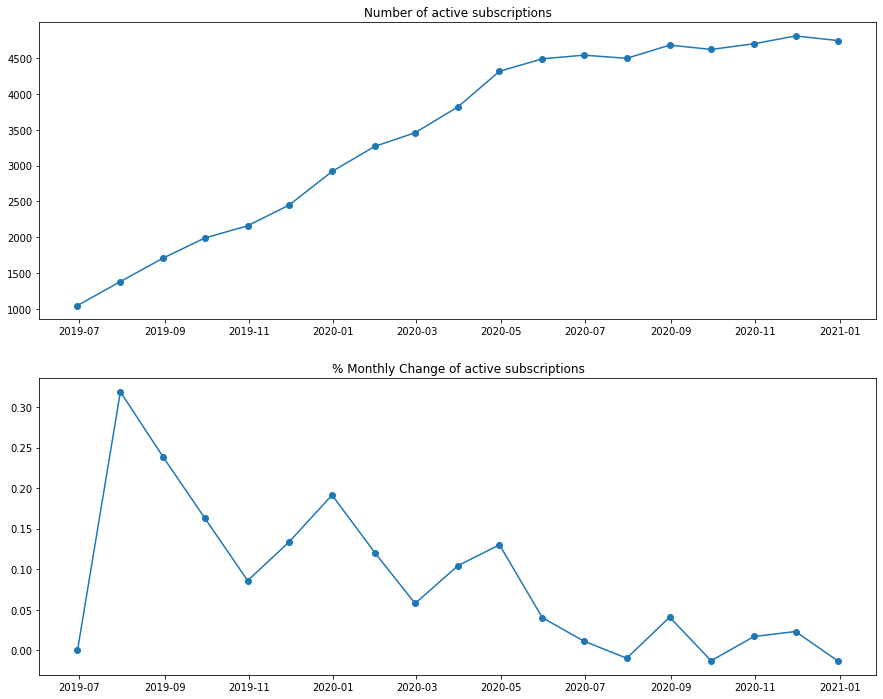

In [10]:
# Plot evolution in number and in percentage by month

df_paid_month = df_paid.copy().dropna()
df_paid_month.iloc[0,2] = 0

plt.figure(figsize=(15,12))

plt.subplot(2,1,1)
plt.title("Number of active subscriptions")
plt.plot(df_paid_month["ACTIVE_SUB"],marker='o')

plt.subplot(2,1,2)
plt.title("% Monthly Change of active subscriptions")
plt.plot(df_paid_month["MONTHLY_PERC_CHANGE"], marker='o');

As we do not have the number of active subscriptions in June 2019, the numbers shown above are biased. However there are two main points:

> The number of **active subscription kept increasing** during the period (June 2019, Decembre 2021).

> But there is a tendency of a **decreasing growth** especially since May 2020.

🔍 **This last point could be explained with the release of Call of Duty Warzone on March 10 2020.** This AAA-game gathered 50 M players in April 2020, so 1 month after its release *(source:https://www.statista.com/statistics/1110000/call-of-duty-warzone-players/)*. Indeed, with the partnership with Activision, the game could be played in multiplayer **without subscription** (normally needed to play online).

**👇 Number of active subscriptions by type:**

In [14]:
segmented_paid = pd.DataFrame()
segmented_paid["SUB_START_DATE"] = data["SUB_START_DATE"].sort_values().drop_duplicates().reset_index(drop=True)
segmented_paid.columns = ["DATE"]

liste_temp = ["Acquisition", "Reclaim", "Renewal"]

for elm in liste_temp:
    segmented_paid[elm] = segmented_paid["DATE"].apply(lambda x: current_active(x,elm))
    
segmented_paid.set_index("DATE", inplace=True)
segmented_paid["TOTAL"] = segmented_paid["Acquisition"] + segmented_paid["Reclaim"] + segmented_paid["Renewal"] 
segmented_paid.head()

,Acquisition,Reclaim,Renewal,TOTAL
DATE,,,,
2019-06-01,8,7,14,29
2019-06-02,9,13,41,63
2019-06-03,13,25,67,105
2019-06-04,19,28,89,136
2019-06-05,20,33,107,160


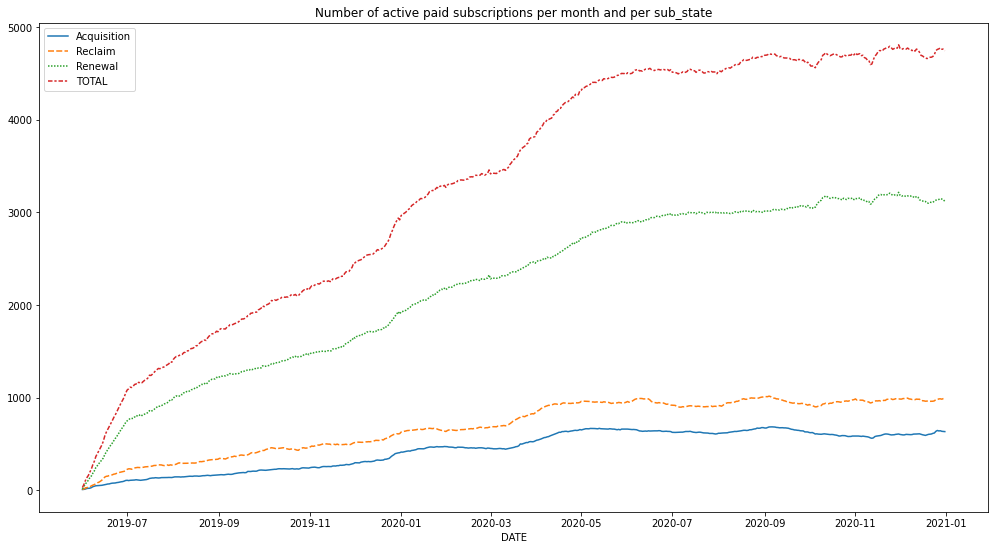

In [17]:
fig = plt.figure(figsize=(17,9))
plt.title("Number of active paid subscriptions per month and per sub_state")
sns.lineplot(data=segmented_paid);

**==> No major tendency can be identified**

**👇 Number of new subscriptions by type:**

## Evolution of "new" subscriptions

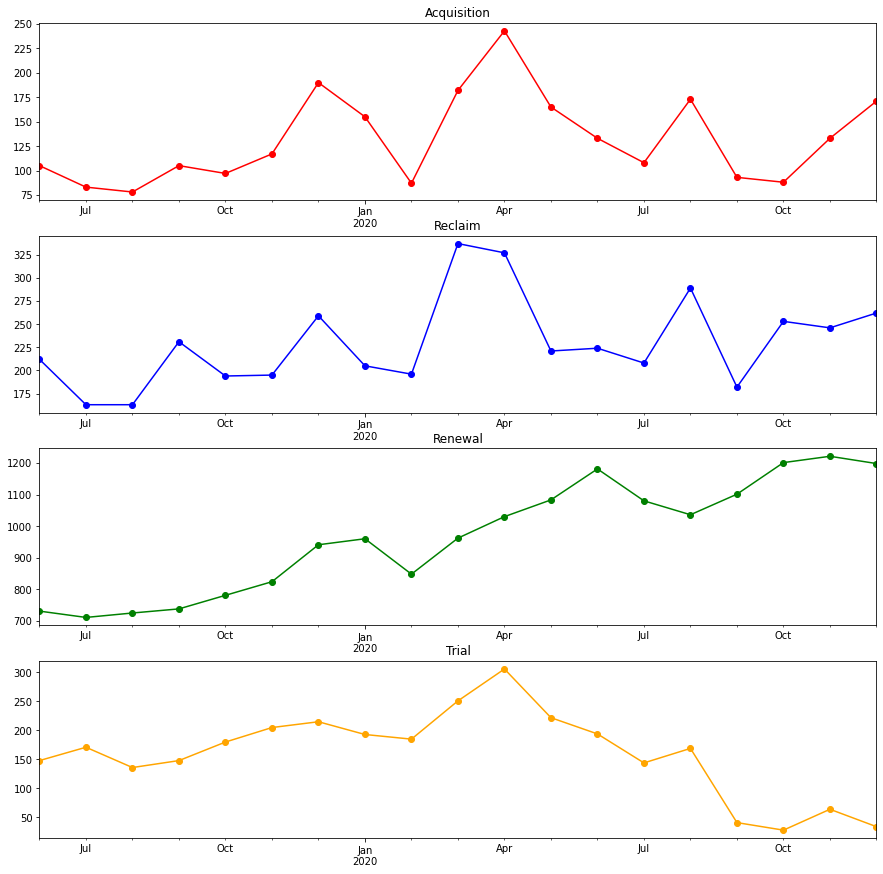

In [18]:
df_by_month= data.copy().set_index("SUB_START_DATE")
df_by_month = pd.DataFrame(df_by_month.groupby([pd.Grouper(freq="M"), "SUB_STATE"])["ACCT_ID"].count())\
                .reset_index().set_index("SUB_START_DATE")
df_by_month.columns = ["SUB_STATE", "SUM"]

plt.figure(figsize=(15,15))

plt.subplot(4,1,1)
plt.title("Acquisition")
df_by_month['SUM'][df_by_month["SUB_STATE"]=="Acquisition"].plot(color='r', marker='o')
plt.xlabel("")
plt.ylabel("")

plt.subplot(4,1,2)
plt.title("Reclaim")
df_by_month['SUM'][df_by_month["SUB_STATE"]=="Reclaim"].plot(color='b', marker='o')
plt.xlabel("")
plt.ylabel("")

plt.subplot(4,1,3)
plt.title("Renewal")
df_by_month['SUM'][df_by_month["SUB_STATE"]=="Renewal"].plot(color='g', marker='o')
plt.xlabel("")
plt.ylabel("")

plt.subplot(4,1,4)
plt.title("Trial")
df_by_month['SUM'][df_by_month["SUB_STATE"]=="Trial"].plot(color='orange', marker='o')
plt.xlabel("")
plt.ylabel("");

We observe 3 peaks for Acquisition and Reclaim in: **December, April, August.** We focus here on these two types because they correspond to "new clients" (i.e customers making a purchase decision). 

> December could be explained with Christmas 

> March/April: correspond to the **first lockdowns in EU** *(interesting map https://ig.ft.com/coronavirus-lockdowns/)ù. With this sanitary context, videogames became a main source of entertainment in a lot of households. Furthermore, in April 2020, the subscription allowed to play to two free games: **Uncharted 4** and DIRT RALLY 2.0. The first one is an exclusivity to the platform 

> Unfortunately, we do not have access to enough data to explain the last peak in August, except holidays

## Focus on individuals

In [20]:
class Customer:
    '''
    Create object customer with its metrics
    '''
    def __init__(self, acct_id):
        self.acct_id = acct_id
        self.df = data[data["ACCT_ID"] == acct_id].reset_index(drop=True)
        self.first_sub = self.df["SUB_STATE"][0]
        self.billable_type = self.df["SUBSCRIPTION_BILLABLE_TYPE"].value_counts().index[0]
        self.subscription_type = self.df["SUBSCRIPTION_TYPE"].value_counts().index[0]
        self.sku_length = self.df["SKU_LENGTH"].value_counts().index[0]
        self.sub_state = self.df["SUB_STATE"].value_counts().index[0]
        self.nb_sub = len(self.df)
        self.duration = total_dur[total_dur["ACCT_ID"] == self.acct_id]["DURATION"]
    
    def custom_df(self):
        '''
        Return metrics within a dataframe
        '''
        temp_dic = {"ACCT_ID":self.acct_id,
                    "FIRST_SUB":self.first_sub,
                    "SUBSCRIPTION_BILLABLE_TYPE":self.billable_type, # Most frequent SUBSCRIPTION_BILLABLE_TYPE
                    "SUBSCRIPTION_TYPE":self.subscription_type, # Most frequent SUBSCRIPTION_TYPE
                    "SKU_LENGTH":self.sku_length, # Most frequent lenght
                    "SUB_STATE":self.sub_state, # Most frequent sub_state
                    "NB_SUB": self.nb_sub,
                    "DURATION":self.duration #Total duration
                   }
        custom_df = pd.DataFrame(temp_dic).reset_index(drop=True)
        return custom_df

In [21]:
# It could be intersting to create a new dataframe focused on individuals
df_indiv = pd.DataFrame()
liste_ID = list(data["ACCT_ID"].unique())

for indiv in liste_ID:
    df_indiv = pd.concat([df_indiv, Customer(indiv).custom_df()])

df_indiv.head()

,ACCT_ID,FIRST_SUB,SUBSCRIPTION_BILLABLE_TYPE,SUBSCRIPTION_TYPE,SKU_LENGTH,SUB_STATE,NB_SUB,DURATION
0,188368000000000,Reclaim,Paid,Wallet,1 month,Renewal,8,245
0,332317000000000,Reclaim,Paid,Wallet,1 month,Reclaim,1,31
0,715785000000000,Trial,Free,Trial,14 days,Trial,1,14
0,124177000000000,Renewal,Paid,Retail,12 months,Renewal,2,731
0,276332000000000,Trial,Free,Trial,14 days,Trial,1,14


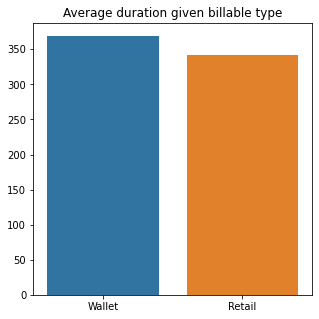

In [63]:
temp = pd.DataFrame({
    "Wallet":[df_indiv[df_indiv["SUBSCRIPTION_TYPE"] == "Wallet"]["DURATION"].mean()],
    "Retail":[df_indiv[df_indiv["SUBSCRIPTION_TYPE"] == "Retail"]["DURATION"].mean()]
})

fig = plt.figure(figsize=(5,5))
plt.title("Average duration given billable type")
sns.barplot(data=temp);

In [73]:
temp = df_indiv.copy()
temp = temp[(temp["SUB_STATE"]!="Trial")&(temp["ACCT_ID"] != "262159000000000")]  #Drop trial account and specific id
temp["SKU_LENGTH"] = temp["SKU_LENGTH"].apply(lambda x: int(x.replace(" months","").replace(" month","")))
temp = temp[["SUB_STATE","SKU_LENGTH","NB_SUB","DURATION"]]
avg_per_type = temp.groupby("SUB_STATE").mean()
avg_per_type

,SKU_LENGTH,NB_SUB,DURATION
SUB_STATE,,,
Acquisition,6.269076,1.340696,254.990629
Reclaim,6.143628,2.117330,313.441672
Renewal,5.573449,5.209741,430.533648


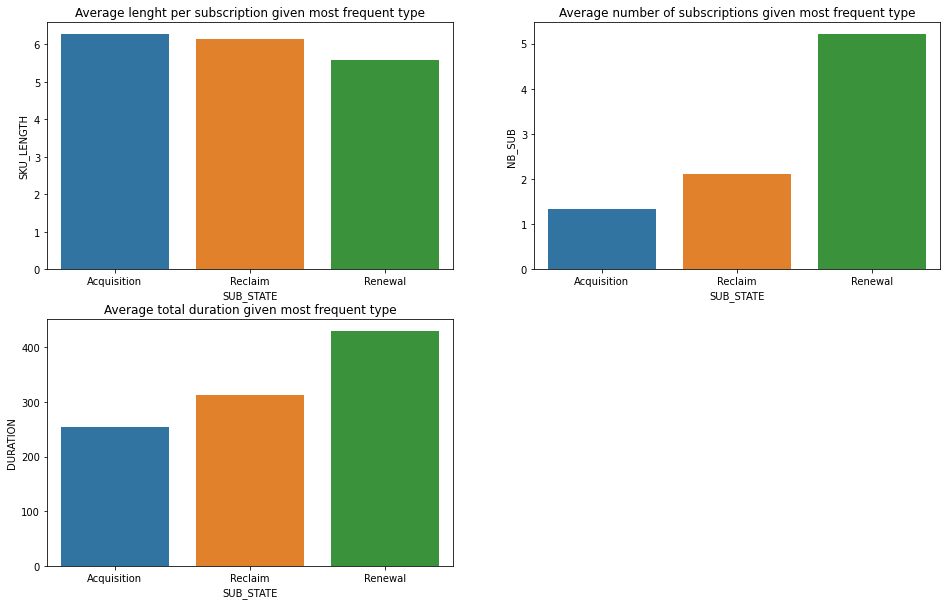

In [78]:
fig = plt.figure(figsize=(16,10))

plt.subplot(2,2,1)
plt.title("Average lenght per subscription given most frequent type")
sns.barplot(x=avg_per_type.index, y="SKU_LENGTH", data=avg_per_type)

plt.subplot(2,2,2)
plt.title("Average number of subscriptions given most frequent type")
sns.barplot(x=avg_per_type.index, y="NB_SUB", data=avg_per_type)

plt.subplot(2,2,3)
plt.title("Average total duration given most frequent type")
sns.barplot(x=avg_per_type.index, y="DURATION", data=avg_per_type);

> As seen with the full dataset, the preferred length subscription is 1 month. There is no significant differences between the most frequent subscription state with an average of c. 6 months. 

> Loyal customers can be identified with a preferred sub_sate "Renewal", and an average duration superior to 1 year.

## Trial efficacity

In [80]:
# Total accounts with a free trial as the first subscription
total_trial = len(df_indiv[(df_indiv["FIRST_SUB"]=="Trial")])

# Total accounts "converted" to paid subscriptions
total_converted = len(df_indiv[(df_indiv["FIRST_SUB"]=="Trial")&(df_indiv["NB_SUB"]>1)&(df_indiv["SUBSCRIPTION_TYPE"]!="Trial")])

print(total_converted/total_trial)

0.10522810522810523


In [83]:
df_indiv[(df_indiv["FIRST_SUB"]=="Trial")&(df_indiv["NB_SUB"]>1)&(df_indiv["SUBSCRIPTION_TYPE"]!="Trial")]["DURATION"].mean()

277.9177215189873

 **Only 10,5%** of total accounts have been converted from trial to paid subscriptions. Furthermore, the average duration for those accounts is low at 278 days.